In [1]:
import torch
import segmentation_models_pytorch as smp
import datasets
import datetime
import numpy as np

from myUtils import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
res = 320
dataset = datasets.PlateDataset(res = res, train = True)

In [3]:
#plot_tensor(dataset[0])

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=12)

In [5]:
ENCODER = 'timm-regnetx_002'
ENCODER_WEIGHTS = 'imagenet'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=3,
    activation='sigmoid',
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [7]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)
# append to file
score = 0
optimizer.param_groups[0]['lr'] = 1e-4
for i in range(0, 250):
    print(f'\nEpoch: {i}')
    train_logs = train_epoch.run(dataloader)
    
    if train_logs['iou_score'] > score:
        torch.save(model, f'./best_model.pth')
    else:
        torch.save(model, f'./checkpoint_model.pth')

    score = train_logs['iou_score']

    with open('./train.log', 'a') as f:
        f.write(f'{i} | {datetime.datetime.now()} | {str(train_logs)}\n')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 100:
        optimizer.param_groups[0]['lr'] = 1e-6
        print('Decrease decoder learning rate to 1e-6!')

    if i == 200:
        optimizer.param_groups[0]['lr'] = 1e-7
        print('Decrease decoder learning rate to 1e-7!')



Epoch: 0
train: 100%|██████████| 56/56 [00:29<00:00,  1.90it/s, dice_loss - 0.02946, iou_score - 0.945] 

Epoch: 1
train: 100%|██████████| 56/56 [00:25<00:00,  2.16it/s, dice_loss - 0.02974, iou_score - 0.9445]

Epoch: 2
train: 100%|██████████| 56/56 [00:26<00:00,  2.13it/s, dice_loss - 0.03067, iou_score - 0.9427]

Epoch: 3
train: 100%|██████████| 56/56 [00:26<00:00,  2.14it/s, dice_loss - 0.03078, iou_score - 0.9425]

Epoch: 4
train: 100%|██████████| 56/56 [00:26<00:00,  2.11it/s, dice_loss - 0.03006, iou_score - 0.9439]

Epoch: 5
train: 100%|██████████| 56/56 [00:25<00:00,  2.16it/s, dice_loss - 0.03055, iou_score - 0.9429]

Epoch: 6
train: 100%|██████████| 56/56 [00:26<00:00,  2.15it/s, dice_loss - 0.03048, iou_score - 0.9431]

Epoch: 7
train: 100%|██████████| 56/56 [00:26<00:00,  2.15it/s, dice_loss - 0.03074, iou_score - 0.9426]

Epoch: 8
train: 100%|██████████| 56/56 [00:25<00:00,  2.16it/s, dice_loss - 0.02965, iou_score - 0.9446]

Epoch: 9
train: 100%|██████████| 56/56 [00:26

KeyboardInterrupt: 

In [8]:
model = torch.load(f'./best_model.pth')

In [9]:
model(dataset[0][0].reshape((1, 3, res, res)).cuda())

tensor([[[[1.7058e-04, 5.6753e-05, 1.8880e-05,  ..., 2.0948e-07,
           5.8886e-07, 1.6554e-06],
          [1.0848e-04, 2.8855e-05, 7.6743e-06,  ..., 1.5929e-07,
           4.4640e-07, 1.2511e-06],
          [6.8990e-05, 1.4670e-05, 3.1193e-06,  ..., 1.2112e-07,
           3.3841e-07, 9.4556e-07],
          ...,
          [4.1675e-07, 1.9058e-07, 8.7152e-08,  ..., 9.1291e-08,
           7.1902e-07, 5.6635e-06],
          [8.4427e-07, 3.9515e-07, 1.8494e-07,  ..., 1.4673e-07,
           1.2391e-06, 1.0464e-05],
          [1.7104e-06, 8.1931e-07, 3.9246e-07,  ..., 2.3583e-07,
           2.1352e-06, 1.9334e-05]],

         [[3.3978e-07, 1.2219e-07, 4.3942e-08,  ..., 2.7932e-06,
           5.9726e-06, 1.2771e-05],
          [1.6067e-07, 5.2583e-08, 1.7209e-08,  ..., 1.8028e-06,
           4.2364e-06, 9.9553e-06],
          [7.5973e-08, 2.2628e-08, 6.7396e-09,  ..., 1.1636e-06,
           3.0050e-06, 7.7602e-06],
          ...,
          [1.4184e-05, 7.6684e-06, 4.1458e-06,  ..., 6.6554

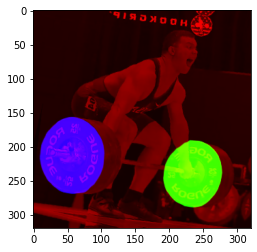

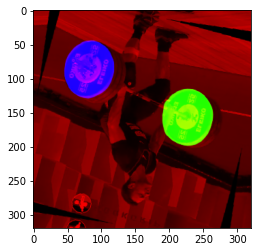

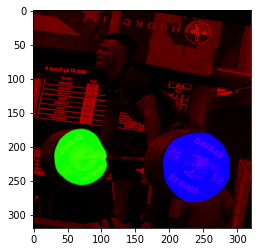

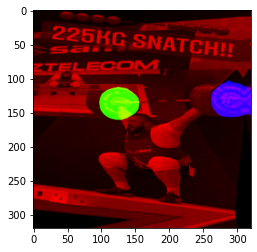

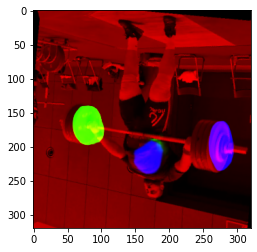

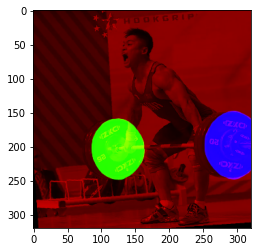

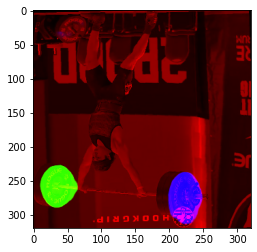

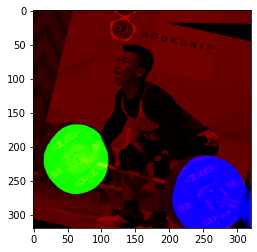

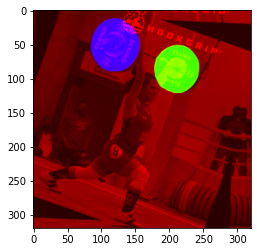

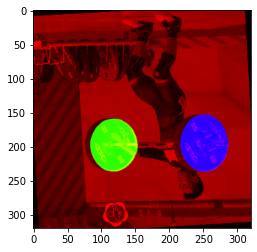

In [10]:
for i in range(10):
    rand = np.random.randint(0, len(dataset))
    plot_pred(dataset[rand][0], model)